<a href="https://colab.research.google.com/github/cbmoliveira/Imagem/blob/main/An%C3%A1lise_de_Imagens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
#gráfico estático
%matplotlib inline
import glob #importa imagem em sequência
from PIL import Image #criar, carregar imagens
import numpy as np 
from scipy import ndimage #processa imagens em várias dimensões
import matplotlib.pyplot as plt
from skimage.io import imsave #lê imagens em vários formatos

In [28]:
import time #ter noção do tempo
t=time.time()

In [29]:
#carregar as imagens 
infiles = sorted(glob.glob('/content/drive/MyDrive/TC/ten/*.tif'))

#abrir a primeira imagem
im = Image.open(infiles[0])

#array zerada para ser preenchida de acordo com os tamanhos das imagens
imgs = np.zeros((len(infiles), im.size[1],im.size[0]))

#Loop que irá adicionando as imagens
i=0
for imfile in infiles:
  im = Image.open(imfile)
  imgs[i,:,:] = np.array(im)
  i+=1

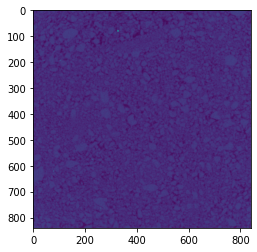

In [30]:
plt.figure()
plt.imshow(im)
plt.show()

In [31]:
from scipy import stats
vmin, vmax = stats.scoreatpercentile(imgs,(0.5,99.5))
imgs = np.clip(imgs, vmin, vmax)
imgs = (imgs - vmin) / (vmax - vmin)
fdg = imgs > 0.4 
obj = ndimage.find_objects(fdg)
sample = imgs[obj[0]]


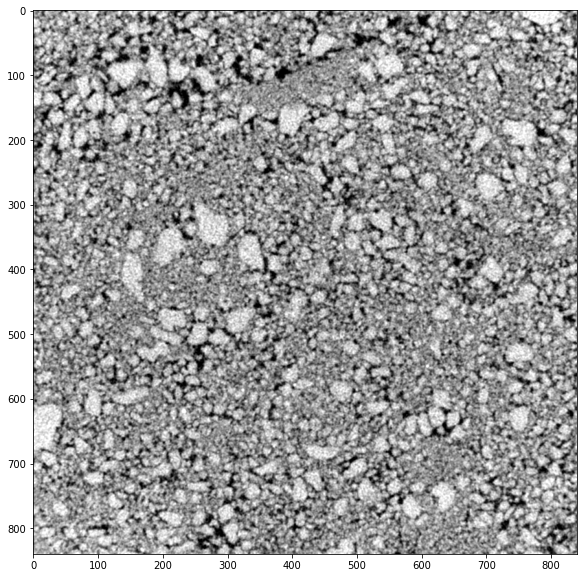

In [32]:
plt.figure(figsize=(10,10))
plt.imshow(sample[0],cmap='gray')
plt.show()

Text(0.5, 1.0, 'Histograma do Stack de Imagens em valores de Voxel')

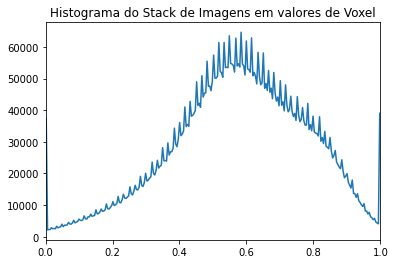

In [33]:
#Histograma das imagens, para que os valores sejam tomados
from skimage import exposure
histo=exposure.histogram(sample)
plt.plot(histo[1], histo[0], label='data')
plt.xlim(0,1)
plt.title('Histograma do Stack de Imagens em valores de Voxel')

Text(0.8, 54680.0, 'Solid')

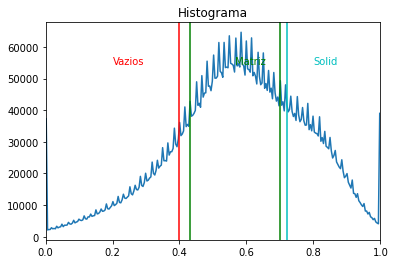

In [34]:
#Marcar as áreas de interesse
void=0.4
matrixmin=0.43
matrixmax=0.7
solid=0.72

#Histograma
from skimage import exposure
histo = exposure.histogram(sample)
plt.plot(histo[1], histo[0], label='data')
plt.xlim(0, 1)
plt.title('Histograma')
plt.axvline(void, color='r', ls='-')
plt.axvline(matrixmin, color='g', ls='-')
plt.axvline(matrixmax, color='g', ls='-')
plt.axvline(solid, color='c', ls='-')
plt.text(void/2, np.max(histo)-10000, 'Vazios', color='r')
plt.text((matrixmin+matrixmax)/2, np.max(histo)-10000, 'Matriz', color='g')
plt.text(0.8, np.max(histo)-10000, 'Solid', color='c')

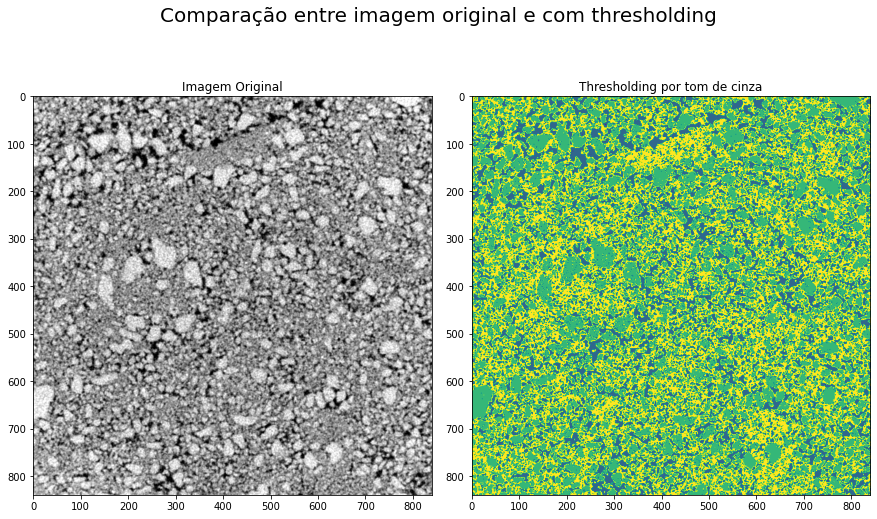

In [35]:
#Utilizando os marcadores na imagem
markers = np.zeros(sample.shape, dtype=np.int8)
markers[sample < void] = 1 #vazios
markers[np.logical_and(sample > matrixmin, sample < matrixmax)] = 3 #matriz
markers[sample > solid] = 2 #solids
#visualise the markers
fig, axes = plt.subplots(ncols=2, figsize=(15, 15))
ax0, ax1= axes
ax0.imshow(sample[0], cmap='gray')
ax0.set_title("Imagem Original")
ax1.imshow(markers[0])
ax1.set_title("Thresholding por tom de cinza")
fig.suptitle('Comparação entre imagem original e com thresholding', y=0.77, fontsize=20)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=None)

Diferença = 6.952380952380949 %


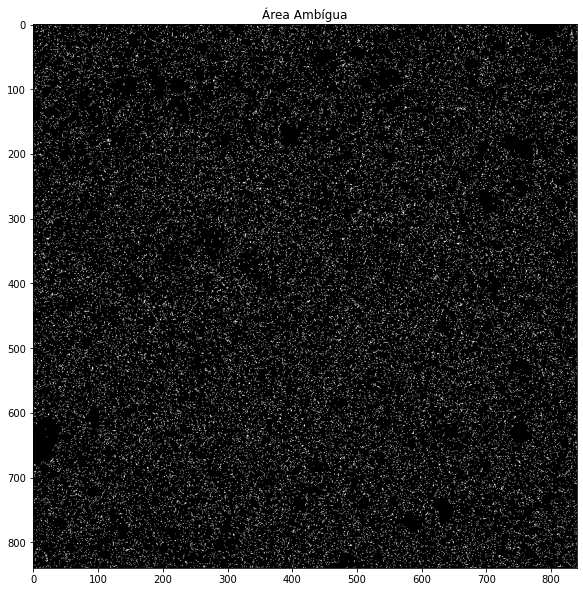

In [36]:
#Área Ambígua

ambiguous=markers[0]==0 # 0= unselected, 1,2,3,4 are marked.
blank=markers[0]!=3 #including 0,1,2,3,4
am=ambiguous.astype(int)
blank=markers[0]!=5 #including 0,1,2,3,4
am=ambiguous.astype(float)
bl=blank.astype(float)
fig, axes = plt.subplots(ncols=1, figsize=(10,10))
ax0= axes
ax0.imshow(ambiguous, cmap='gray')
ax0.set_title("Área Ambígua")

i1 = Image.fromarray(am)
i2 = Image.fromarray(bl)
pairs = zip(i1.getdata(), i2.getdata())
dif = sum(abs(p1-p2) for p1,p2 in pairs)
ncomponents = i1.size[0] * i1.size[1]
per = (dif / 1 * 100) / ncomponents
print('Diferença =', 100-per, '%')


In [37]:
!pip install pyamg

In [74]:
#Scikit randomwalker
from skimage import segmentation
rw = segmentation.random_walker(sample, markers, beta=500, mode='bf', copy=False, return_full_prob=False)#beta=diffusion difficulty
#generate possibility map
pm = segmentation.random_walker(sample, markers, beta=500, mode='bf', copy=False, return_full_prob=True)#beta=diffusion difficulty
#Scikit watershed
from skimage.morphology import watershed as ws
ws = ws(sample, markers)
#Kmeans-clustering
from skimage.segmentation import slic
km = slic(sample, n_segments=4, compactness=0.01, multichannel=False, enforce_connectivity=False)
#OpenCV watershed: can only work with 8bit 3-channel image (color image)
#cv2.watershed(sample,markers)

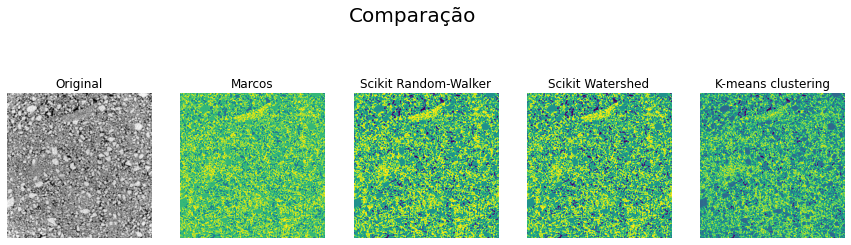

In [75]:
fig, axes = plt.subplots(nrows =1, ncols=5, figsize=(15, 15))
ax0, ax1, ax2, ax3, ax4 = axes
ax0.imshow(sample[i], cmap='gray')
ax0.set_title("Original")
ax0.axis('off')
ax1.imshow(markers[i])
ax1.set_title('Marcos',fontsize=12)
ax1.axis('off')
ax2.imshow(rw[i])
ax2.set_title('Scikit Random-Walker',fontsize=12)
ax2.axis('off')
ax3.imshow(ws[i])
ax3.set_title('Scikit Watershed',fontsize=12)
ax3.axis('off')
ax4.imshow(km[i])
ax4.set_title('K-means clustering',fontsize=12)
ax4.axis('off')
fig.suptitle('Comparação', y=0.65, fontsize=20)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

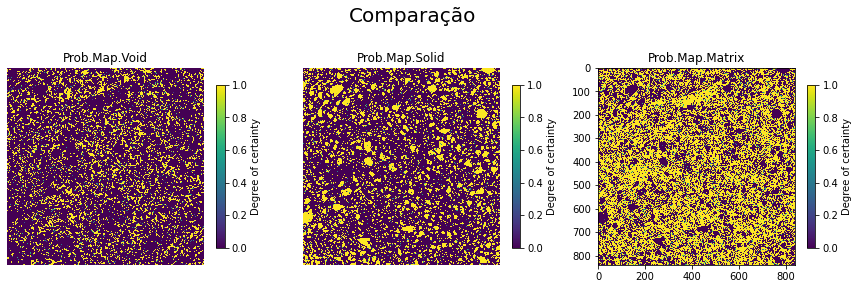

In [76]:
fig, axes = plt.subplots(nrows =1, ncols=3, figsize=(15, 15))
ax0, ax1, ax2 = axes
ax0.imshow(pm[0,i])
ax0.set_title('Prob.Map.Void',fontsize=12)
ax0.axis('off')
ax1.imshow(pm[1,i])
ax1.set_title('Prob.Map.Solid',fontsize=12)
ax1.axis('off')
ax2.imshow(pm[2,i])
ax2.set_title('Prob.Map.Matrix',fontsize=12)
cax2 = ax2.imshow(pm[2,i], interpolation='nearest', vmin=0, vmax=1)
cax1 = ax1.imshow(pm[1,i], interpolation='nearest', vmin=0, vmax=1)
cax0 = ax0.imshow(pm[0,i], interpolation='nearest', vmin=0, vmax=1)
cb0 = fig.colorbar(cax0,ax=ax0,shrink=0.2)
cb1 = fig.colorbar(cax1,ax=ax1,shrink=0.2)
cb2 = fig.colorbar(cax2,ax=ax2,shrink=0.2)
cb0.ax.set_ylabel('Degree of certainty', rotation=90)
cb1.ax.set_ylabel('Degree of certainty', rotation=90)
cb2.ax.set_ylabel('Degree of certainty', rotation=90)
fig.suptitle('Comparação', y=0.65, fontsize=20)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)